In [1]:
from scipy.optimize import minimize
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import numpy as np
from qiskit import execute, Aer
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ

from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
%matplotlib inline

import xlwt
from xlwt import Workbook

In [2]:
backend = Aer.get_backend('qasm_simulator') 
T = 8192 # number of shots

In [3]:
def val_form(val_form, entanglement_gate,theta,depth,qr,cr,qc): 
    
    if val_form == "RY":
        if len(theta) == depth*2+2:
            qc.ry(theta[0],qr[0])
            qc.ry(theta[1],qr[1])
            qc.barrier()
        else:
            raise Exception('The length of parameter list should be:{}'.format(depth*2+2))
        
        if entanglement_gate == "rz":
            for i in range(depth):
                qc.cz(qr[0],qr[1])
                qc.ry(theta[2*i+2],qr[0])
                qc.ry(theta[2*i+3],qr[1])
                qc.barrier()
        elif entanglement_gate == "rx":
            for i in range(depth):
                qc.cx(qr[0],qr[1])
                qc.ry(theta[2*i+2],qr[0])
                qc.ry(theta[2*i+3],qr[1])
                qc.barrier()
        else:
            raise Exception("Unindentified Entanglement Gate")
          
            
    elif val_form == "RYRZ":
        if len(theta) == depth*4+4:
            qc.ry(theta[0],qr[0])
            qc.ry(theta[1],qr[1])
            qc.rz(theta[2],qr[0])
            qc.rz(theta[3],qr[1])
            qc.barrier()
            
        else:
            raise Exception('The length of parameter list should be:{}'.format(depth*4+4))
    
        if entanglement_gate == "rz":
            for i in range(depth):
                qc.cz(qr[0],qr[1])
                qc.ry(theta[4*i+4],qr[0])
                qc.ry(theta[4*i+5],qr[1])
                qc.rz(theta[4*i+6],qr[0])
                qc.rz(theta[4*i+7],qr[1])
                qc.barrier()
                
        elif entanglement_gate == "rx":
            for i in range(depth):
                qc.cx(qr[0],qr[1])
                qc.ry(theta[4*i+4],qr[0])
                qc.ry(theta[4*i+5],qr[1])
                qc.rz(theta[4*i+6],qr[0])
                qc.rz(theta[4*i+7],qr[1])
                qc.barrier()
      
        else:
            raise Exception("Unindentified Entanglement Gate")
            
    else:
        raise Exception("Unindentified Variation Form")   
    qc.draw(output="mpl")

In [4]:
def Z0I(theta):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)
    
#    val_form(variational_form, entangled_gate,theta[:p*depth+p],depth,qr,cr,qc)
    val_form(variational_form, entangled_gate,theta,depth,qr,cr,qc)
    qc.z(qr[0])    
    qc.measure(qr,cr)
    
    shots = T
    max_credits = 3
    
    job_Z0I = execute(qc, backend=backend, shots=shots,max_credits=max_credits)
    result_Z0I = job_Z0I.result()
    counts_Z0I = result_Z0I.get_counts(qc)
    
    exp_val = 0
    if "00" in list (counts_Z0I):
        exp_val=exp_val+counts_Z0I["00"]/T
    if "01" in list (counts_Z0I):
        exp_val=exp_val+counts_Z0I["01"]/T
    if "10" in list (counts_Z0I):
        exp_val=exp_val-counts_Z0I["10"]/T
    if "11" in list (counts_Z0I):
        exp_val=exp_val-counts_Z0I["11"]/T
    del qc,qr,cr
    return exp_val

def IZ1(theta):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)
    
#    val_form(variational_form, entangled_gate,theta[p*depth+p:],depth,qr,cr,qc)
    val_form(variational_form, entangled_gate,theta,depth,qr,cr,qc)
    qc.z(qr[1])    
    qc.measure(qr,cr)
    
    shots = T
    max_credits = 3
    
    job_IZ1 = execute(qc, backend=backend, shots=shots,max_credits=max_credits)
    result_IZ1 = job_IZ1.result()
    counts_IZ1 = result_IZ1.get_counts(qc)

    exp_val = 0
    if "00" in list (counts_IZ1):
        exp_val=exp_val+counts_IZ1["00"]/T
    if "01" in lis t (counts_IZ1):
        exp_val=exp_val-counts_IZ1["01"]/T
    if "10" in list (counts_IZ1):
        exp_val=exp_val+counts_IZ1["10"]/T
    if "11" in list (counts_IZ1):
        exp_val=exp_val-counts_IZ1["11"]/T
    del qc,qr,cr
    return exp_val
  

In [5]:
def h00(R):
    return (-1 + np.exp(-2*R)*(2+2/R) - 2/R + np.exp(-R)*(-(1/3)*(R**2)-3*R-3))/(2 + np.exp(-R)*((2/3)*(R**2)+2*R+2))

def h11(R):
    return (-1 + np.exp(-2*R)*(2+2/R) - 2/R - np.exp(-R)*(-(1/3)*(R**2)-3*R-3))/(2 - np.exp(-R)*((2/3)*(R**2)+2*R+2))

In [6]:
def partial_opt_exp_val_a0(theta):
    total_energy = 0.5*h00(R)-0.5*h00(R)*(Z0I(theta))
    return total_energy

def partial_opt_exp_val_a1(theta):
    total_energy = 0.5*h11(R)-0.5*h11(R)*(IZ1(theta))
    return total_energy

In [10]:
begin_distance = 0.1 # Bohr
end_distance   = 2   # Bohr
bond_distance = np.arange(begin_distance,end_distance+0.1 ,0.1)
energy_VQE_cobyla_a0 = np.zeros(len(bond_distance))
repulsion = 1/bond_distance

for i,R in enumerate(bond_distance):
    iter_num = 0
    variational_form = "RY"
    if variational_form == "RYRZ":
        p = 4
    elif variational_form == "RY":
        p = 2
    entangled_gate = "rx"
    depth = 2
    theta = np.random.rand(p*depth+p)
    print("Processing distance: {:.2f} ".format(R),end='\r')
    res = minimize(partial_opt_exp_val_a0,theta, method="cobyla", tol=1e-5,options={"disp":True})
    energy_VQE_cobyla_a0[i] = res.fun
    
    

In [11]:
begin_distance = 0.1 # Bohr
end_distance   = 10   # Bohr
bond_distance = np.arange(begin_distance,end_distance+0.1 ,0.1)
energy_VQE_cobyla_a1 = np.zeros(len(bond_distance))
repulsion = 1/bond_distance

for i,R in enumerate(bond_distance):
    iter_num = 0
    variational_form = "RY"
    if variational_form == "RYRZ":
        p = 4
    elif variational_form == "RY":
        p = 2
    entangled_gate = "rx"
    depth = 2
    theta = np.random.rand(p*depth+p)
    print("Processing distance: {:.2f} ".format(R),end='\r')
    res = minimize(partial_opt_exp_val_a1,theta, method="cobyla", tol=1e-5,options={"disp":True})
    energy_VQE_cobyla_a1[i] = res.fun

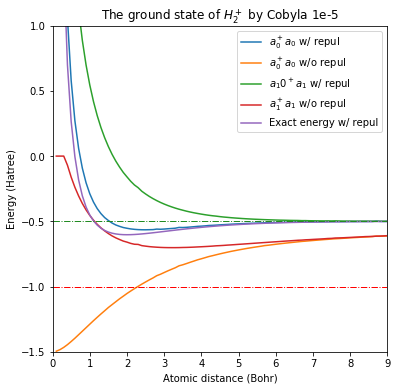

In [9]:
exact = [8.02176,3.07138,1.46663,0.69925,0.26501,-0.00482,-0.18262,-0.30448,-0.39027,-0.45179,-0.49641,-0.52897,-0.55274,-0.56998,-0.58232,-0.59094,-0.5967,-0.60025,-0.60211,-0.60263,-0.60213,-0.60084,-0.59893,-0.59655,-0.59382,-0.59083,-0.58766,-0.58436,-0.58098,-0.57756,-0.57414,-0.57074,-0.56738,-0.56408,-0.56086,-0.55771,-0.55465,-0.55169,-0.54884,-0.54608,-0.54344,-0.5409,-0.53847,-0.53615,-0.53394,-0.53183,-0.52983,-0.52793,-0.52613,-0.52442,-0.52281,-0.52129,-0.51985,-0.5185,-0.51723,-0.51604,-0.51492,-0.51387,-0.51289,-0.51197,-0.51111,-0.51031,-0.50956,-0.50886,-0.50822,-0.50761,-0.50705,-0.50653,-0.50604,-0.50559,-0.50518,-0.50479,-0.50443,-0.5041,-0.50379,-0.50351,-0.50325,-0.503,-0.50278,-0.50257,-0.50238,-0.5022,-0.50204,-0.50189,-0.50175,-0.50162,-0.5015,-0.50139,-0.50129,-0.5012,-0.50111,-0.50103,-0.50096,-0.50089,-0.50083,-0.50077,-0.50072,-0.50067,-0.50062,-0.50058]

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(bond_distance, energy_VQE_cobyla_a0+repulsion,   label="$a_0^+a_0$ w/ repul")
plt.plot(bond_distance, energy_VQE_cobyla_a0,   label="$a_0^+a_0$ w/o repul")
plt.plot(bond_distance, energy_VQE_cobyla_a1+repulsion,   label="$a_10^+a_1$ w/ repul")
plt.plot(bond_distance, energy_VQE_cobyla_a1,   label="$a_1^+a_1$ w/o repul")
plt.plot(bond_distance, exact,   label="Exact energy w/ repul")

plt.title("The ground state of $H_2^+$ by Cobyla 1e-5")
plt.xlabel('Atomic distance (Bohr)')
plt.ylabel('Energy (Hatree)')
plt.xlim(0,9)
plt.ylim(-1.5,1)
plt.axhline(-1,  linestyle='-.',linewidth = 1,color="red")
plt.axhline(-0.5,  linestyle='-.',linewidth = 1,color="forestgreen")
plt.legend()
plt.show()